v6-1c

CIFAR10 32x32

Unet(input_blocks)

In [1]:
import torch
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm
import os
import random

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [3]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

In [4]:
version = "v9-3c"

OUTPUT_DIR = '/root/' + version + '/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [5]:
def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

In [6]:
class CFG:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    num_classes = 10
    batch_size = 256

In [7]:
transform_train = transforms.Compose([transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
                                      transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      transforms.RandomRotation(10),     #Rotates the image to a specified angel
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
                               ])
 
 
transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
training_dataset = datasets.CIFAR10(root='/root/', train=True, download=True, transform=transform_train) # Data augmentation is only done on training images
validation_dataset = datasets.CIFAR10(root='/root/', train=False, download=True, transform=transform)
 
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=CFG.batch_size, shuffle=True) # Batch size of 100 i.e to work with 100 images at a time
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = CFG.batch_size, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [8]:
def im_convert(tensor):  
  image = tensor.cpu().clone().detach().numpy() # This process will happen in normal cpu.
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [9]:
# Different classes in CIPHAR 10 dataset. 
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

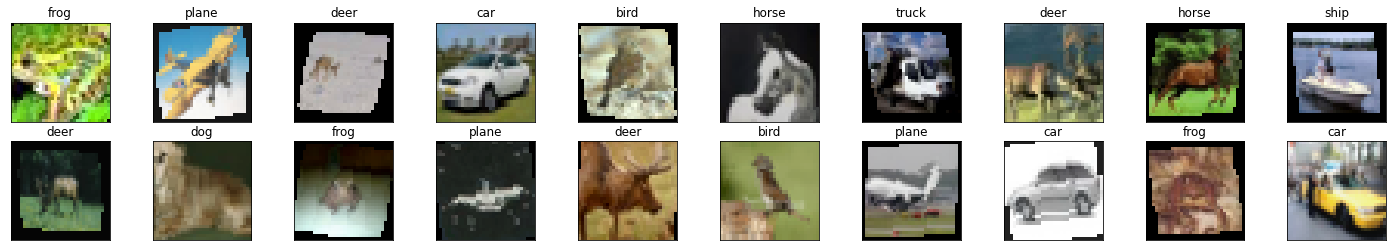

In [10]:
# We iter the batch of images to display
dataiter = iter(training_loader) # converting our train_dataloader to iterable so that we can iter through it. 
images, labels = dataiter.next() #going from 1st batch of 100 images to the next batch
fig = plt.figure(figsize=(25, 4)) 

# We plot 20 images from our train_dataset
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) 
  plt.imshow(im_convert(images[idx])) #converting to numpy array as plt needs it.
  ax.set_title(classes[labels[idx].item()])

In [11]:
from datetime import datetime
from functools import partial
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.models import resnet
from tqdm import tqdm
import argparse
import json
import math
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import glob

parser = argparse.ArgumentParser(description='Train MoCo on CIFAR-10')

parser.add_argument('-a', '--arch', default='resnet18')

# lr: 0.06 for batch 512 (or 0.03 for batch 256)
parser.add_argument('--lr', '--learning-rate', default=0.06, type=float, metavar='LR', help='initial learning rate', dest='lr')
parser.add_argument('--epochs', default=200, type=int, metavar='N', help='number of total epochs to run')
parser.add_argument('--schedule', default=[120, 160], nargs='*', type=int, help='learning rate schedule (when to drop lr by 10x); does not take effect if --cos is on')
parser.add_argument('--cos', action='store_true', help='use cosine lr schedule')

parser.add_argument('--batch-size', default=512, type=int, metavar='N', help='mini-batch size')
parser.add_argument('--wd', default=5e-4, type=float, metavar='W', help='weight decay')

# moco specific configs:
parser.add_argument('--moco-dim', default=128, type=int, help='feature dimension')
parser.add_argument('--moco-k', default=4096, type=int, help='queue size; number of negative keys')
parser.add_argument('--moco-m', default=0.99, type=float, help='moco momentum of updating key encoder')
parser.add_argument('--moco-t', default=0.1, type=float, help='softmax temperature')

parser.add_argument('--bn-splits', default=8, type=int, help='simulate multi-gpu behavior of BatchNorm in one gpu; 1 is SyncBatchNorm in multi-gpu')

parser.add_argument('--symmetric', action='store_true', help='use a symmetric loss function that backprops to both crops')

# knn monitor
parser.add_argument('--knn-k', default=200, type=int, help='k in kNN monitor')
parser.add_argument('--knn-t', default=0.1, type=float, help='softmax temperature in kNN monitor; could be different with moco-t')

# utils
parser.add_argument('--resume', default='', type=str, metavar='PATH', help='path to latest checkpoint (default: none)')
'''
args = parser.parse_args()  # running in command line
'''
args = parser.parse_args('')  # running in ipynb

# set command line arguments here when running in ipynb
args.epochs = 100
args.cos = True
args.schedule = []  # cos in use
args.symmetric = False

print(args)

class SplitBatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        
    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            running_mean_split = self.running_mean.repeat(self.num_splits)
            running_var_split = self.running_var.repeat(self.num_splits)
            outcome = nn.functional.batch_norm(
                input.view(-1, C * self.num_splits, H, W), running_mean_split, running_var_split, 
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
            self.running_mean.data.copy_(running_mean_split.view(self.num_splits, C).mean(dim=0))
            self.running_var.data.copy_(running_var_split.view(self.num_splits, C).mean(dim=0))
            return outcome
        else:
            return nn.functional.batch_norm(
                input, self.running_mean, self.running_var, 
                self.weight, self.bias, False, self.momentum, self.eps)

class ModelBase(nn.Module):
    """
    Common CIFAR ResNet recipe.
    Comparing with ImageNet ResNet recipe, it:
    (i) replaces conv1 with kernel=3, str=1
    (ii) removes pool1
    """
    def __init__(self, feature_dim=128, arch=None, bn_splits=16):
        super(ModelBase, self).__init__()

        # use split batchnorm
        norm_layer = partial(SplitBatchNorm, num_splits=bn_splits) if bn_splits > 1 else nn.BatchNorm2d
        resnet_arch = getattr(resnet, arch)
        net = resnet_arch(num_classes=feature_dim, norm_layer=norm_layer)

        self.net = []
        for name, module in net.named_children():
            if name == 'conv1':
                module = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
            if isinstance(module, nn.MaxPool2d):
                continue
            if isinstance(module, nn.Linear):
                self.net.append(nn.Flatten(1))
            self.net.append(module)

        self.net = nn.Sequential(*self.net)

    def forward(self, x):
        x = self.net(x)
        # note: not normalized here
        return x
    

Namespace(arch='resnet18', batch_size=512, bn_splits=8, cos=True, epochs=100, knn_k=200, knn_t=0.1, lr=0.06, moco_dim=128, moco_k=4096, moco_m=0.99, moco_t=0.1, resume='', schedule=[], symmetric=False, wd=0.0005)


In [12]:
class Model(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.encoder_q = ModelBase(feature_dim=128, arch='resnet18', bn_splits=8)
        self.fc1 = nn.Linear(128, 10)
            
    
    def forward(self, x):
        x = self.encoder_q(x)
        x = nn.functional.normalize(x, dim=1)
        return self.fc1(x)

In [13]:
# import torch
# tmp = torch.load("v9-5/model_best.pth")['state_dict']
# state_dict = {k:v for k,v in tmp.items() if 'encoder_q' in k}
# torch.save(state_dict, "v9-5/encoder_q.pth")

In [14]:
model = Model()    
# msg = model.load_state_dict(torch.load('/root/v9-5/encoder_q.pth'), strict=False)

In [15]:
# msg.missing_keys

In [16]:
model.to(CFG.device) # run our model on cuda GPU for faster results
print("")

In [17]:
criterion = nn.CrossEntropyLoss() # same as categorical_crossentropy loss used in Keras models which runs on Tensorflow
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001) # fine tuned the lr
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002) # fine tuned the lr

In [ ]:
epochs = 25
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
LOGGER.info('Step,Train Loss,Train Auc,Valid Loss,Valid Auc')
for e in range(epochs): # training our model, put input according to every batch.
  
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    train_num = 0
    val_num = 0

    tqdm_bar = tqdm(training_loader, desc=f'Training Epoch {e} ', total=int(len(training_loader)))
    for i, (inputs, labels) in enumerate(tqdm_bar):
        inputs = inputs.to(CFG.device) # input to device as our model is running in mentioned device.
        labels = labels.to(CFG.device)
        
        model.train()
        outputs = model(inputs) # every batch of 100 images are put as an input.
        loss = criterion(outputs, labels) # Calc loss after each batch i/p by comparing it to actual labels. 

        optimizer.zero_grad() #setting the initial gradient to 0
        loss.backward() # backpropagating the loss
        optimizer.step() # updating the weights and bias values for every single step.

        _, preds = torch.max(outputs, 1) # taking the highest value of prediction.
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data) # calculating te accuracy by taking the sum of all the correct predictions in a batch.
        
        train_num += len(preds)
        
        tqdm_bar.set_postfix(train_loss=running_loss/(i+1), train_accuracy=running_corrects.item()/(train_num))
    else:
        with torch.no_grad(): # we do not need gradient for validation.
            tqdm_bar = tqdm(validation_loader, desc=f'Validation Epoch {e} ', total=int(len(validation_loader)))
            for i, (val_inputs, val_labels) in enumerate(tqdm_bar):
                val_inputs = val_inputs.to(CFG.device)
                val_labels = val_labels.to(CFG.device)
                
                #t = torch.randint(0, 4000, (len(val_labels),), device=dist_util.dev()).long()
                model.eval()
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)

                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)
                
                val_num += len(val_preds)
                
                tqdm_bar.set_postfix(val_loss=val_running_loss/(i+1), val_accuracy=val_running_corrects.item()/(val_num))
      
        epoch_loss = running_loss/len(training_loader) # loss per epoch
        epoch_acc = running_corrects.float()/ train_num # accuracy per epoch
        running_loss_history.append(epoch_loss) # appending for displaying 
        running_corrects_history.append(epoch_acc)

        val_epoch_loss = val_running_loss/len(validation_loader)
        val_epoch_acc = val_running_corrects.float()/ val_num
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        print('epoch :', (e+1))
        print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
        print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))
        # LOGGER.info('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
        # LOGGER.info('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))
        LOGGER.info('{:d}, {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format((e+1) * len(training_loader), epoch_loss, epoch_acc.item(), val_epoch_loss, val_epoch_acc.item()))

Step,Train Loss,Train Auc,Valid Loss,Valid Auc
Validation Epoch 0 : 100%|██████████| 40/40 [00:02<00:00, 13.75it/s, val_accuracy=0.428, val_loss=1.54]
196, 1.8108, 0.3386, 1.5360, 0.4279


epoch : 1
training loss: 1.8108, acc 0.3386 
validation loss: 1.5360, validation acc 0.4279 


Validation Epoch 1 : 100%|██████████| 40/40 [00:02<00:00, 16.68it/s, val_accuracy=0.579, val_loss=1.17]
392, 1.3875, 0.5046, 1.1698, 0.5789


epoch : 2
training loss: 1.3875, acc 0.5046 
validation loss: 1.1698, validation acc 0.5789 


Validation Epoch 2 : 100%|██████████| 40/40 [00:02<00:00, 13.58it/s, val_accuracy=0.641, val_loss=1.02]
588, 1.1285, 0.6020, 1.0194, 0.6408


epoch : 3
training loss: 1.1285, acc 0.6020 
validation loss: 1.0194, validation acc 0.6408 


Validation Epoch 3 : 100%|██████████| 40/40 [00:02<00:00, 13.46it/s, val_accuracy=0.715, val_loss=0.807]
784, 0.9632, 0.6636, 0.8068, 0.7153


epoch : 4
training loss: 0.9632, acc 0.6636 
validation loss: 0.8068, validation acc 0.7153 


Validation Epoch 4 : 100%|██████████| 40/40 [00:02<00:00, 13.60it/s, val_accuracy=0.729, val_loss=0.804]
980, 0.8456, 0.7043, 0.8038, 0.7286


epoch : 5
training loss: 0.8456, acc 0.7043 
validation loss: 0.8038, validation acc 0.7286 


Validation Epoch 5 : 100%|██████████| 40/40 [00:02<00:00, 13.55it/s, val_accuracy=0.769, val_loss=0.675]
1176, 0.7568, 0.7385, 0.6750, 0.7690


epoch : 6
training loss: 0.7568, acc 0.7385 
validation loss: 0.6750, validation acc 0.7690 


Validation Epoch 6 : 100%|██████████| 40/40 [00:02<00:00, 13.79it/s, val_accuracy=0.791, val_loss=0.614]
1372, 0.6862, 0.7636, 0.6135, 0.7910


epoch : 7
training loss: 0.6862, acc 0.7636 
validation loss: 0.6135, validation acc 0.7910 


Validation Epoch 7 : 100%|██████████| 40/40 [00:02<00:00, 16.47it/s, val_accuracy=0.817, val_loss=0.547]
1568, 0.6277, 0.7860, 0.5473, 0.8173


epoch : 8
training loss: 0.6277, acc 0.7860 
validation loss: 0.5473, validation acc 0.8173 


Validation Epoch 8 : 100%|██████████| 40/40 [00:03<00:00, 13.17it/s, val_accuracy=0.834, val_loss=0.499]
1764, 0.5790, 0.8009, 0.4995, 0.8339


epoch : 9
training loss: 0.5790, acc 0.8009 
validation loss: 0.4995, validation acc 0.8339 


Validation Epoch 9 : 100%|██████████| 40/40 [00:03<00:00, 13.20it/s, val_accuracy=0.844, val_loss=0.461]
1960, 0.5376, 0.8180, 0.4613, 0.8444


epoch : 10
training loss: 0.5376, acc 0.8180 
validation loss: 0.4613, validation acc 0.8444 


Validation Epoch 10 : 100%|██████████| 40/40 [00:02<00:00, 13.79it/s, val_accuracy=0.844, val_loss=0.455]
2156, 0.4988, 0.8305, 0.4550, 0.8437


epoch : 11
training loss: 0.4988, acc 0.8305 
validation loss: 0.4550, validation acc 0.8437 


Validation Epoch 11 : 100%|██████████| 40/40 [00:03<00:00, 13.32it/s, val_accuracy=0.853, val_loss=0.442]
2352, 0.4717, 0.8415, 0.4419, 0.8532


epoch : 12
training loss: 0.4717, acc 0.8415 
validation loss: 0.4419, validation acc 0.8532 


Validation Epoch 12 : 100%|██████████| 40/40 [00:02<00:00, 13.95it/s, val_accuracy=0.856, val_loss=0.434]
2548, 0.4423, 0.8458, 0.4345, 0.8563


epoch : 13
training loss: 0.4423, acc 0.8458 
validation loss: 0.4345, validation acc 0.8563 


Validation Epoch 13 : 100%|██████████| 40/40 [00:02<00:00, 13.53it/s, val_accuracy=0.863, val_loss=0.4]  
2744, 0.4142, 0.8570, 0.4004, 0.8629


epoch : 14
training loss: 0.4142, acc 0.8570 
validation loss: 0.4004, validation acc 0.8629 


Validation Epoch 14 : 100%|██████████| 40/40 [00:03<00:00, 12.31it/s, val_accuracy=0.877, val_loss=0.364]
2940, 0.3893, 0.8667, 0.3637, 0.8774


epoch : 15
training loss: 0.3893, acc 0.8667 
validation loss: 0.3637, validation acc 0.8774 


Validation Epoch 15 : 100%|██████████| 40/40 [00:03<00:00, 11.89it/s, val_accuracy=0.878, val_loss=0.368]
3136, 0.3679, 0.8734, 0.3684, 0.8785


epoch : 16
training loss: 0.3679, acc 0.8734 
validation loss: 0.3684, validation acc 0.8785 


Validation Epoch 16 : 100%|██████████| 40/40 [00:02<00:00, 13.35it/s, val_accuracy=0.881, val_loss=0.357]
3332, 0.3431, 0.8807, 0.3566, 0.8806


epoch : 17
training loss: 0.3431, acc 0.8807 
validation loss: 0.3566, validation acc 0.8806 


Validation Epoch 17 : 100%|██████████| 40/40 [00:02<00:00, 13.56it/s, val_accuracy=0.871, val_loss=0.398]
3528, 0.3236, 0.8880, 0.3980, 0.8706


epoch : 18
training loss: 0.3236, acc 0.8880 
validation loss: 0.3980, validation acc 0.8706 


Validation Epoch 18 : 100%|██████████| 40/40 [00:02<00:00, 13.37it/s, val_accuracy=0.866, val_loss=0.389]
3724, 0.3156, 0.8898, 0.3886, 0.8660


epoch : 19
training loss: 0.3156, acc 0.8898 
validation loss: 0.3886, validation acc 0.8660 


Validation Epoch 19 : 100%|██████████| 40/40 [00:03<00:00, 12.03it/s, val_accuracy=0.885, val_loss=0.351]
3920, 0.2939, 0.8993, 0.3507, 0.8854


epoch : 20
training loss: 0.2939, acc 0.8993 
validation loss: 0.3507, validation acc 0.8854 


Validation Epoch 20 : 100%|██████████| 40/40 [00:02<00:00, 13.73it/s, val_accuracy=0.89, val_loss=0.328] 
4116, 0.2774, 0.9042, 0.3279, 0.8900


epoch : 21
training loss: 0.2774, acc 0.9042 
validation loss: 0.3279, validation acc 0.8900 


Validation Epoch 21 : 100%|██████████| 40/40 [00:02<00:00, 13.72it/s, val_accuracy=0.892, val_loss=0.34] 
4312, 0.2601, 0.9087, 0.3397, 0.8918


epoch : 22
training loss: 0.2601, acc 0.9087 
validation loss: 0.3397, validation acc 0.8918 


Validation Epoch 22 : 100%|██████████| 40/40 [00:03<00:00, 12.83it/s, val_accuracy=0.896, val_loss=0.323]
4508, 0.2518, 0.9134, 0.3226, 0.8959


epoch : 23
training loss: 0.2518, acc 0.9134 
validation loss: 0.3226, validation acc 0.8959 


Validation Epoch 23 : 100%|██████████| 40/40 [00:02<00:00, 13.89it/s, val_accuracy=0.9, val_loss=0.305]  
4704, 0.2365, 0.9180, 0.3049, 0.9001


epoch : 24
training loss: 0.2365, acc 0.9180 
validation loss: 0.3049, validation acc 0.9001 


Validation Epoch 24 :  45%|████▌     | 18/40 [00:01<00:01, 11.91it/s, val_accuracy=0.892, val_loss=0.327]